## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

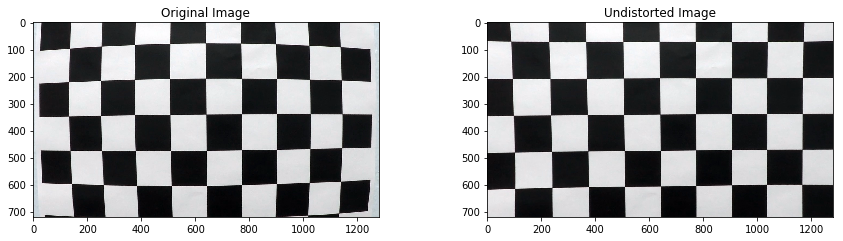

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Helper Function to illustrate processing methods
def plot_side_by_side(img1, img2, cap1, cap2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(cap1, fontsize=12)
    ax2.imshow(img2)
    ax2.set_title(cap2, fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
# Method to Calibrate Camera with the Given Images
def calib_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Compute camera calibration matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs, images

# Calibrate camera
ret, mtx, dist, rvecs, tvecs, images = calib_camera()

# Apply distortion correction to some example calib image
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plot_side_by_side(img, undistorted, 'Original Image', 'Undistorted Image')

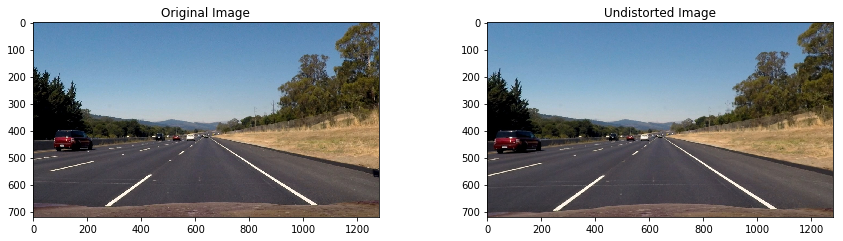

In [2]:
# Test pipeline step by step

# Load test images
test_images = glob.glob('test_images/straight*.jpg')

# Read test image with straight lanes
img = mpimg.imread(test_images[0])

# Plot undistorted test image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plot_side_by_side(img, undistorted, 'Original Image','Undistorted Image')

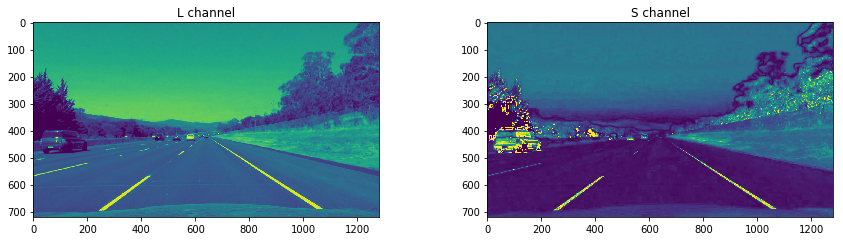

In [3]:
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
plot_side_by_side(l_channel, s_channel, 'L channel','S channel')

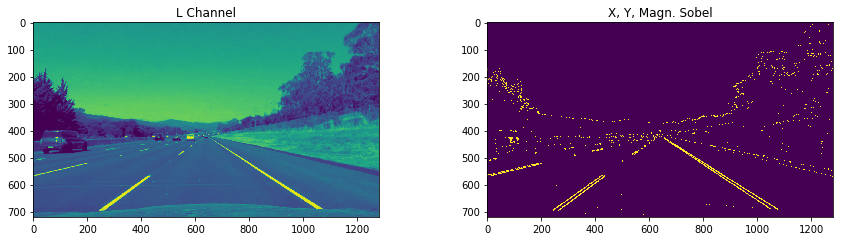

In [4]:
# Sobel in y, x direction on L channel
thr_magnitude = 40
thr_in_x = 20

grad_l_min = 0.7
grad_l_max = 1.4

lx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = 5)
ly = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = 5)
gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
l_mag = np.sqrt(lx**2 + ly**2)

slm = np.uint8(255*l_mag/np.max(l_mag))
slx = np.uint8(255*lx/np.max(lx))
sly = np.uint8(255*ly/np.max(ly))

sobel_img = np.zeros_like(l_channel)
sobel_cond1 = slm > thr_magnitude
sobel_cond2 = slx > thr_in_x
sobel_cond3 = (gradl > grad_l_min) & (gradl < grad_l_max)
sobel_img[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1 

plot_side_by_side(l_channel, sobel_img, 'L Channel','X, Y, Magn. Sobel')

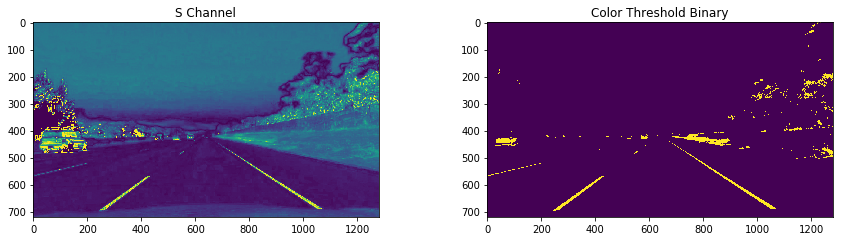

In [5]:
# Threshold color channel on Saturation and Light

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205

color_img = np.zeros_like(s_channel)
color_cond1 = (s_channel > sat_thresh) & (l_channel > light_thresh)
color_cond2 = l_channel > light_thresh_agr
color_img[(color_cond1 | color_cond2)] = 1

plot_side_by_side(s_channel, color_img, 'S Channel','Color Threshold Binary')

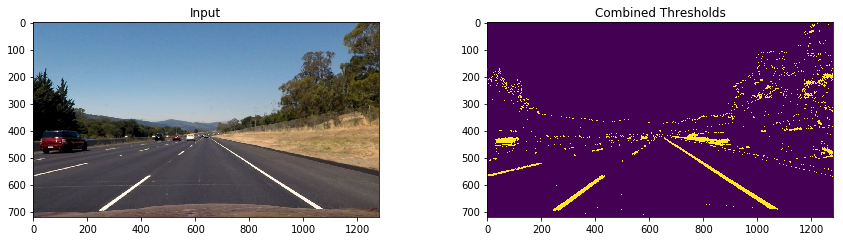

In [6]:
# Combine the two binary thresholds
combined_thre = cv2.bitwise_or(sobel_img, color_img)
combined_thre=np.uint8(255*combined_thre/np.max(combined_thre))

plot_side_by_side(undistorted, combined_thre, 'Input','Combined Thresholds')

## Perspective Transform

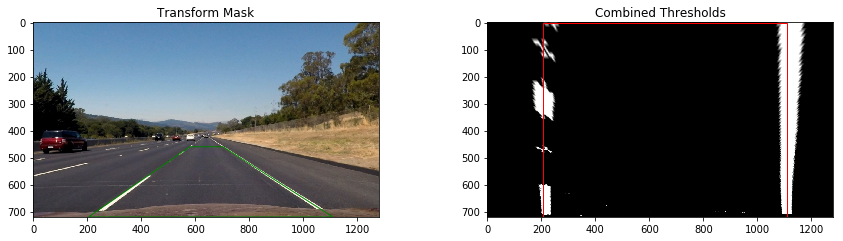

In [8]:
# Grab the image shape
img_size = (undistorted.shape[1], undistorted.shape[0])

#top-left, top-right, bottom-right, and bottom-left polygon
src = np.float32([[580,460], [205,720], [1110,720], [703,460]])
#dst = np.float32([[320,0], [320,720], [960,720], [960,0]])
dst = np.float32([[205,0], [205,720], [1110,720], [1110,0]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(combined_thre, M, img_size)

# Plot the src and dst polygons
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title("Transform Mask", fontsize=12)
ax2.imshow(warped, cmap="gray")
ax2.set_title("Combined Thresholds", fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Create a Rectangle patch
src = patches.Polygon(src,fill=False,color="green")

# Create a Rectangle patch
dst = patches.Polygon(dst,fill=False,color="red")

# Add the patch to the Axes
ax1.add_patch(src)
ax2.add_patch(dst)
plt.show()

In [9]:
binary_warped=warped
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit, right_fit)

[ 1.21472781e-04 -8.94388866e-02  2.24293407e+02] [-3.23666636e-06 -2.57786334e-02  1.12528092e+03]


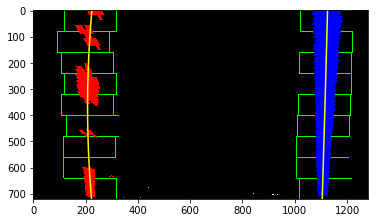

In [62]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()

## All in One Pipeline

In [63]:
def lane_detect(img, mtx, dist):
    # Apply distortion correction to calib image.
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel in y, x direction on Light channel
    thr_magnitude = 40
    thr_in_x = 20

    grad_l_min = 0.7
    grad_l_max = 1.4

    lx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)

    slm = np.uint8(255*l_mag/np.max(l_mag))
    slx = np.uint8(255*lx/np.max(lx))
    sly = np.uint8(255*ly/np.max(ly))

    sobel_img = np.zeros_like(l_channel)
    sobel_cond1 = slm > thr_magnitude
    sobel_cond2 = slx > thr_in_x
    sobel_cond3 = (gradl > grad_l_min) & (gradl < grad_l_max)
    sobel_img[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1 
    
    # Threshold color channel on Saturation and Light
    sat_thresh = 120
    light_thresh = 40
    light_thresh_agr = 205

    color_img = np.zeros_like(s_channel)
    color_cond1 = (s_channel > sat_thresh) & (l_channel > light_thresh)
    color_cond2 = l_channel > light_thresh_agr
    color_img[(color_cond1 | color_cond2)] = 1
    
    # Combine the two binary thresholds
    combined_thre = cv2.bitwise_or(sobel_img, color_img)
    combined_thre=np.uint8(255*combined_thre/np.max(combined_thre))
    
    return undistorted, combined_thre

def warp_image(image):
    
    #top-left, top-right, bottom-right, and bottom-left
    src = np.float32([[580,460], [205,720], [1110,720], [703,460]])
    dst = np.float32([[320,0], [320,720], [960,720], [960,0]])
    
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    image = cv2.warpPerspective(image, M, img_size)
    return image

def fit_lanes(binary_warped, bTracking, nwindows=19, margin=100, minpix=100):
    
    # Fit tracking
    global left_fit_tracking_list
    global right_fit_tracking_list
    
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Use fit tracking if video sequence
    if bTracking:
        
        # tracking list length
        list_length=20

        # Left lane fit tracking
        if len(left_fit_tracking_list)==0:
            left_fit_tracking_list.append(left_fit)
      
        if len(left_fit_tracking_list)<=list_length:
            left_fit_tracking_list.append(left_fit)
        else: 
            left_fit_tracking_list.pop(0)
            left_fit_tracking_list.append(left_fit)

        c2=np.median(list(zip(*left_fit_tracking_list))[0])
        c1=np.median(list(zip(*left_fit_tracking_list))[1])
        c0=np.median(list(zip(*left_fit_tracking_list))[2])

        left_fit = c2, c1, c0

        # Right lane fit tracking
        if len(right_fit_tracking_list)==0:
            right_fit_tracking_list.append(right_fit)

        if len(right_fit_tracking_list)<=list_length:
            right_fit_tracking_list.append(right_fit)
        else: 
            right_fit_tracking_list.pop(0)
            right_fit_tracking_list.append(right_fit)

        c2=np.median(list(zip(*right_fit_tracking_list))[0])
        c1=np.median(list(zip(*right_fit_tracking_list))[1])
        c0=np.median(list(zip(*right_fit_tracking_list))[2])

        right_fit = c2, c1, c0
        
    return left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

def plot_fit(binary_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, margin=100):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    left=np.array((left_fitx,ploty), np.int32).T
    right=np.array((right_fitx,ploty), np.int32).T
    left_poly = np.zeros_like(window_img)
    right_poly = np.zeros_like(window_img)
    cv2.polylines(left_poly, [left], False, (0,255,255),thickness=4)
    cv2.polylines(right_poly, [right], False, (0,255,255),thickness=4)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    # Overlay results
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)   
    result = cv2.add(result, left_poly)
    result = cv2.add(result, right_poly)
    
    return result, left_fitx, right_fitx, ploty

def overlay_results(result, left_fitx, right_fitx, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ploty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ploty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,str(left_curverad/1000.0)+" km",(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,str(right_curverad/1000.0)+" km",(800,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    # Calculate offset from center
    lane_mid=(left_fitx[-1] + right_fitx[-1])/2
    lane_offset=xm_per_pix * (result.shape[1]/2-lane_mid)
    
    cv2.putText(result,str(lane_offset)+" m Offset From Center",(10,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    return result

def unwarp_image(binary_warped, undistorted, left_fitx, right_fitx, ploty):
    
    #top-left, top-right, bottom-right, and bottom-left
    src = np.float32([[580,460], [205,720], [1110,720], [703,460]])
    dst = np.float32([[320,0], [320,720], [960,720], [960,0]])
    
    # Transform back from bird view
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
    return result
    

def pipeline(mtx, dist, img, bTracking, back_transform=False, plot=True):
    
    # Preprocessing image for lane detect
    undistorted, combined_thre=lane_detect(img, mtx, dist)
    
    # Warp image to birds view
    binary_warped=warp_image(combined_thre)

    # Fit lanes
    left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = fit_lanes(binary_warped, bTracking)   
    
    # Plot fit
    result, left_fitx, right_fitx, ploty=plot_fit(binary_warped, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
       
    # Transform back from birds view
    if back_transform:
        result=unwarp_image(binary_warped,undistorted, left_fitx, right_fitx, ploty)
        
    # Overlay radius, offset etc. on image
    result=overlay_results(result, left_fitx, right_fitx, ploty)
        
    # For single image processing
    if plot:
        plt.imshow(result)
        plt.show()
        
    return result

## Test Pipeline on All Test Images

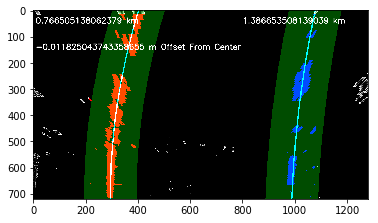

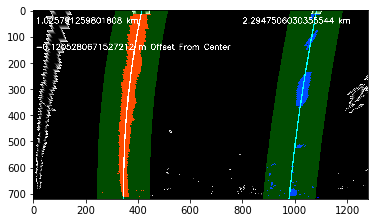

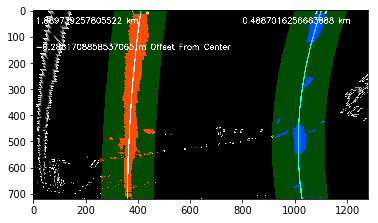

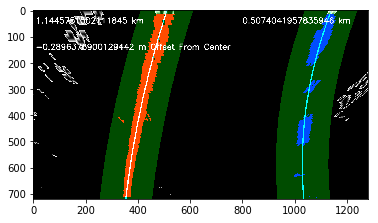

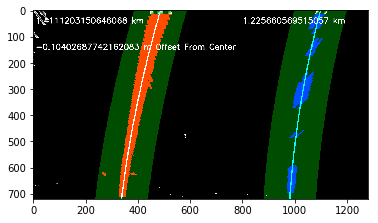

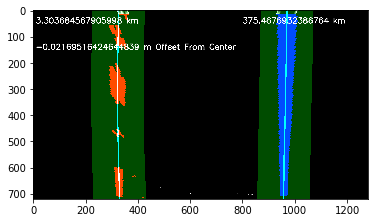

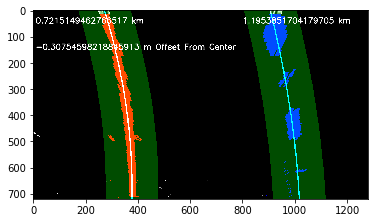

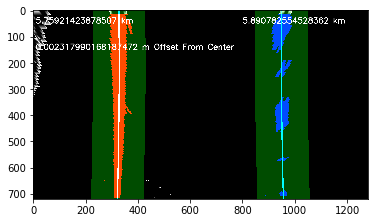

In [64]:
#read all images
img_file_names=os.listdir("test_images/")

for i in range(0,len(img_file_names)):
    img = mpimg.imread("test_images/"+img_file_names[i])
    result = pipeline(mtx, dist, img, bTracking=False)
    cv2.imwrite("output_images/output_"+img_file_names[i],result) #imsave somehow not working

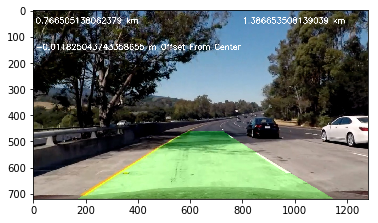

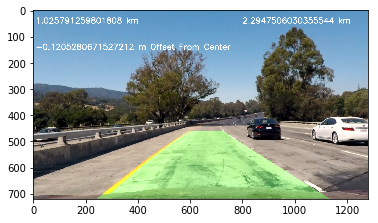

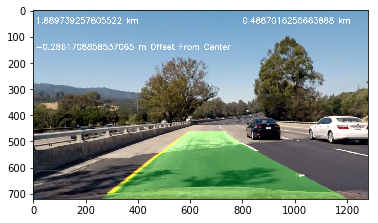

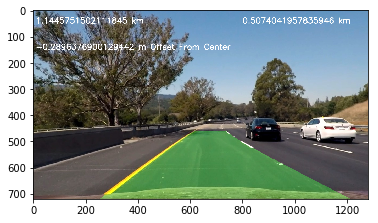

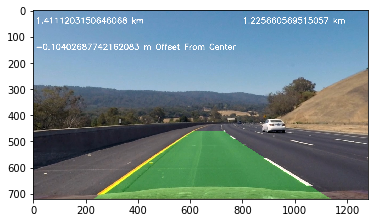

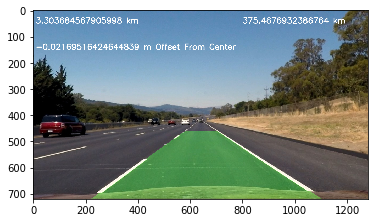

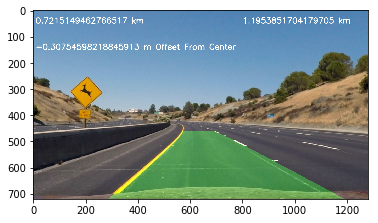

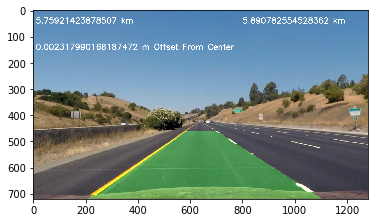

In [65]:
#process all test images
for i in range(0,len(img_file_names)):
    img = mpimg.imread("test_images/"+img_file_names[i])
    result = pipeline(mtx, dist, img, bTracking=False, back_transform=True)

In [66]:
# Define function handle for Video sequence
def process_image(image):
    result = pipeline(mtx, dist, image, plot=False)
    return result

def process_image_w_back_transform(image):
    result = pipeline(mtx, dist, image, plot=False, back_transform=True, bTracking=True)
    return result

In [61]:
# Process video
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

#init fit tracker
left_fit_tracking_list=[]
right_fit_tracking_list=[]

out_clip = clip.fl_image(process_image_w_back_transform)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:20<02:49,  6.54it/s]


 24%|██▍       | 303/1261 [00:40<02:09,  7.40it/s]


 36%|███▌      | 454/1261 [01:00<01:53,  7.12it/s]


 48%|████▊     | 605/1261 [01:20<01:25,  7.70it/s]


 60%|█████▉    | 756/1261 [01:40<01:06,  7.54it/s]


 72%|███████▏  | 907/1261 [02:01<00:47,  7.48it/s]


 84%|████████▍ | 1057/1261 [02:21<00:26,  7.56it/s]


 96%|█████████▌| 1205/1261 [02:41<00:07,  7.53it/s]


100%|█████████▉| 1260/1261 [02:48<00:00,  7.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 37s, sys: 26.2 s, total: 3min 3s
Wall time: 2min 49s


In [68]:
output = 'challenge_video_output.mp4'
clip = VideoFileClip("challenge_video.mp4")

#init fit tracker
left_fit_tracking_list=[]
right_fit_tracking_list=[]

out_clip = clip.fl_image(process_image_w_back_transform)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



100%|██████████| 485/485 [01:00<00:00,  8.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 59.2 s, sys: 5.92 s, total: 1min 5s
Wall time: 1min 1s


In [69]:
output = 'harder_challenge_video_output.mp4'
clip = VideoFileClip("harder_challenge_video.mp4")

#init fit tracker
left_fit_tracking_list=[]
right_fit_tracking_list=[]

out_clip = clip.fl_image(process_image_w_back_transform) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:58<00:00,  7.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 2min 52s, sys: 18.7 s, total: 3min 11s
Wall time: 2min 58s
